# **Introduction to this lab:**
In this lab, we will be doing a classification of the Quran Reciters. The dataset being used is an opensource dataset from Kaggle. You can read more about the data [here](https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification/). In this lab we will be doing audio classification. Feel free to change the dataset and try other datasets.



# 1. Initializations and Dataset Download
Lets start by downloading the dataset and installing the necessary library for downloading directly with the link from kaggle.

In [1]:
!pip install librosa scikit-image --quiet

In [ ]:
!pip install -U datasets --quiet --upgrade
from datasets import load_dataset
dataset = load_dataset("westbrook/English_Accent_DataSet", split="train")


Repo card metadata block was not found. Setting CardData to empty.


{'audio_id': Value(dtype='string', id=None), 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'raw_text': Value(dtype='string', id=None), 'gender': Value(dtype='string', id=None), 'speaker_id': Value(dtype='string', id=None), 'duration': Value(dtype='float32', id=None), 'accent': ClassLabel(names=['Dutch', 'German', 'Czech', 'Polish', 'French', 'Hungarian', 'Finnish', 'Romanian', 'Slovak', 'Spanish', 'Italian', 'Estonian', 'Lithuanian', 'Croatian', 'Slovene', 'English', 'Scottish', 'Irish', 'NorthernIrish', 'Indian', 'Vietnamese', 'Canadian', 'American'], id=None), 'split': Value(dtype='string', id=None)}


In [36]:
print(dataset.features['accent'])

ClassLabel(names=['Dutch', 'German', 'Czech', 'Polish', 'French', 'Hungarian', 'Finnish', 'Romanian', 'Slovak', 'Spanish', 'Italian', 'Estonian', 'Lithuanian', 'Croatian', 'Slovene', 'English', 'Scottish', 'Irish', 'NorthernIrish', 'Indian', 'Vietnamese', 'Canadian', 'American'], id=None)


# 2. Imports
Then we will write all our imports, keep in mind that PyTorch is not automatically detects and trains on GPU, you have to tell it to use `cuda`. In case you want to train on Mac Silicon replace cuda with `mps`.

In [18]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import librosa # Library that is used to read and process audio files
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
from transformers import Wav2Vec2Model, Wav2Vec2Processor # Wav2Vec2 Model and Processor
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory
import time # Used to calculate time for each epoch or any processing time in seconds
from skimage.transform import resize # Used to resize the images and we will use it to resize audio waves

# detect the GPU if any, if not use CPU, change "cuda" to "mps" if you have a mac
device = "mps"

# 3. Data
The dataset consists of audio samples and their corresponding labels (accents). We will organize this data into a pandas DataFrame, where each row contains the audio array and its label.

We will then inspect the shape of the DataFrame, check the distribution of classes, and visualize the first 5 rows.

Note: The way we process and organize the data may vary depending on the dataset structure.


In [19]:
audio_arrays = [sample["audio"]["array"] for sample in dataset]
labels = [sample["accent"] for sample in dataset]

data_df = pd.DataFrame({"audio": audio_arrays, "label": labels})
print(data_df.shape) 
print(data_df["label"].value_counts()) 
data_df.head() 

(50382, 2)
label
15    13511
22     8351
16     7541
17     4167
21     2993
18     2465
19     1351
9      1182
0      1148
1      1069
2       937
3       858
4       756
10      717
5       641
6       571
20      563
7       553
8       385
11      266
12      175
13      120
14       62
Name: count, dtype: int64


,audio,label
0,"[-0.006103515625, -0.008758544921875, -0.00729...",15
1,"[-0.00018310546875, -0.000274658203125, -0.000...",15
2,"[-9.1552734375e-05, -0.0001220703125, -9.15527...",15
3,"[-0.003021240234375, -0.005584716796875, -0.00...",15
4,"[-9.1552734375e-05, -0.000152587890625, -0.000...",15


# 3.1
This code is used to balance the dataset by ensuring each class has the same number of samples. It works as follows:

- It loops through each unique label in the DataFrame.
- For each label, it selects all rows (sub_df) with that label.
- If there are at least 120 samples for that label, it randomly samples 120 rows and adds them to a list.
- After processing all labels, it concatenates the sampled DataFrames into a new balanced DataFrame (data_df), where each class has exactly 120 samples.
- Finally, it prints the new class distribution and shows the first few rows.

In [20]:
new_dfs = []
for i in data_df["label"].unique():
    sub_df = data_df[data_df['label'] == i]
    if len(sub_df) >= 250:
        new_dfs.append(sub_df.sample(250))

data_df = pd.concat(new_dfs)

print(data_df["label"].value_counts())

data_df.head()

print()

label
15    250
3     250
11    250
6     250
5     250
2     250
21    250
18    250
22    250
7     250
20    250
17    250
16    250
9     250
4     250
0     250
1     250
10    250
19    250
8     250
Name: count, dtype: int64



# 4. Data investigation
Now lets dig deeper into our dataset. In the cell below we print the shape of the data which is represented by (rows, columns), then we plot the data distribution for each class. we can see below that our dataset is balanced.

Data Shape is:  (5000, 2)


Claases Distrubution is: 


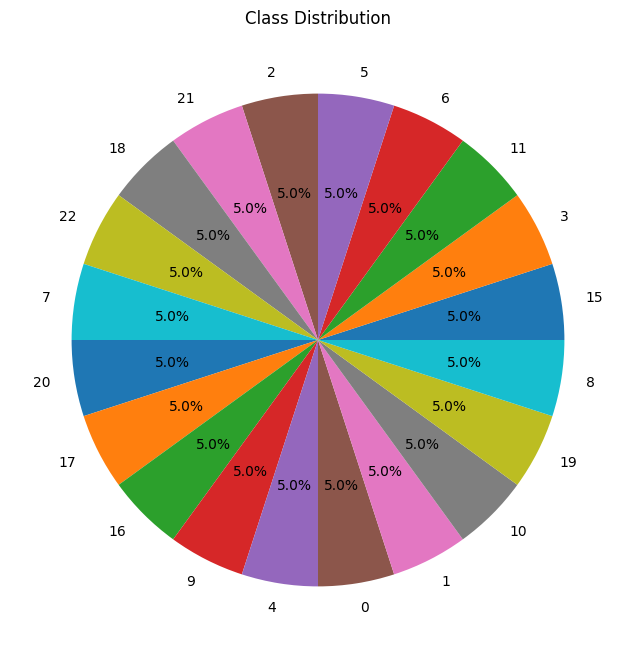

In [21]:
print("Data Shape is: ", data_df.shape) 
print()

print()
print("Claases Distrubution is: ")

class_counts = data_df['label'].value_counts() 
plt.figure(figsize=(8, 8))

plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')


plt.title('Class Distribution') 

plt.show() 


# 5. Data Split
Now lets split the dataset into training, validation and testing. Here we will be using it in a bit different way since we will be reading the image paths from the dataframe so better we split the dataframe directly and then read the images. We will do that by getting a random sample of 70% from our data using data_df.sample(frac=0.7,random_state=7) then we will create a new variable of test dataset which we will drop from it the 70% of the train which means that it will be 30% of the data which is the rest of the data using data_df.drop(train.index). Then we will do the same between testing to create validation which will be 50% of the data which means the final split we have is the following:

* Training: 70%
* Validation: 15%
* Testing: 15%

In [22]:
train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%


print("Training Shape: ", train.shape) # Print the Trainnig shape (rows, columns)
print("Validation Shape: ", val.shape) # Print the Validation shape (rows, columns)
print("Testing Shape: ", test.shape) # Print the Testing shape (rows, columns)

Training Shape:  (3500, 2)
Validation Shape:  (750, 2)
Testing Shape:  (750, 2)


# 6. Custom Dataset Class

Now lets create some preprocessing objects, first we start by LabelEncoder which converts string classes to numeric for example instead of having the classes as (x, y) it will be (0,1) because machines understands numbers only.


* `__init__(self, dataframe):`
    When you create an instance of CustomAudioDataset, you need to provide a dataframe (a kind of table with data that we read before).
    Inside this function:
    * self.dataframe: stores the provided dataframe.
    * self.labels: converts the 'Class' column of the dataframe into numeric values with the label encoder we created before. Then moving them to the device (like a GPU `cuda` we defined before) for faster computation.
    * self.audios: loads the audio files listed in the 'FilePath' column of the dataframe and converts each audio file into a spectrogram (a visual representation of the spectrum of frequencies in the audio file).


* `__len__(self):`
    This function tells you how many items are in the dataset. Keep in mind that this function is available in the original `Dataset` class in PyTorch but with the concept of inheritance, we are taking this function and overwriting it.

* `__getitem__(self, idx)`:
    This function is used to get a specific item from the dataset by its index (idx).
    It retrieves the audio and its corresponding label for the given index and prepares them in the required format for the machine learning model. Keep in mind that this function is available in the original `Dataset` class in PyTorch but we also are taking this function and overwriting it.

* `get_spectrogram(self, file_path)`:
    This is a helper function to convert an audio file into a spectrogram.
    It involves several steps:
    * Loading the audio file.
    * Computing its spectrogram, which is a visual way to represent the different frequencies present in the audio.
    * Converting the spectrogram to a decibel (dB) scale, which makes it easier to visualize.
    * Resizing the spectrogram to a fixed size, which is necessary because the machine learning model expects inputs of a consistent size.

In [23]:
class CustomAudioDataset(Dataset):
    def __init__(self, dataframe, sr=22050, duration=5):
        self.dataframe = dataframe
        self.labels = dataframe["label"].astype(int).tolist()
        self.audio_arrays = dataframe["audio"].tolist()
        self.sr = sr
        self.duration = duration
        self.img_height = 128
        self.img_width = 256

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        signal = self.audio_arrays[idx]
        label = self.labels[idx]
        spec = self.get_spectrogram(signal)

        # Normalize
        spec = (spec - spec.mean()) / (spec.std() + 1e-5)

        return torch.tensor(spec, dtype=torch.float32).unsqueeze(0), torch.tensor(label, dtype=torch.long)

    def get_spectrogram(self, signal):
        spec = librosa.feature.melspectrogram(y=signal, sr=self.sr, n_fft=2048, hop_length=512, n_mels=self.img_height)
        spec_db = librosa.power_to_db(spec, ref=np.max)
        spec_resized = librosa.util.fix_length(spec_db, size=self.img_width, axis=1)
        return spec_resized


# 7. Create Dataset Objects
In this cell we will create 3 objects from the dataset class we created before. Those will be for training, validation and testing.

In [24]:
train_dataset = CustomAudioDataset(dataframe=train)
val_dataset = CustomAudioDataset(dataframe=val)
test_dataset = CustomAudioDataset(dataframe=test)

# 8. Hyperparameters
Now we are setting the training hyperparameters, we defined some variables which are the learning rate, batch size and training epoch.

In [25]:
LR = 1e-5
BATCH_SIZE = 4
EPOCHS = 25

# 9. DataLoaders
PyTorch provides a class called DataLoader which allows us to create objects of it to simplify the training. Dataloader is an object that we can loop through it to train according to batches. When we start training, we loop through epochs, if you skip the batch size it means that the amount of training data in one batch is equal to the complete amount of training data, this method is not efficient and in most of the cases you need to train through using batches. Dataloader allows you to loop through the batches easily during the training. When you create a dataloader. You define the batch size and enable the `shuffle` to randomize the data and then you can loop through it in each epoch to train normally.

In [26]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 10. Model

This code defines a neural network class named Net which inherits from the class `nn.module` in PyTorch.

* `__init__(self):`
  This is where the neural network is set up. Each layer of the network is defined here.
  self.conv1, self.conv2, self.conv3: These are convolutional layers. They are particularly good at processing data that has a grid-like topology, like images (or in this case, spectrograms from audio data). They work by sliding a small window over the input and transforming the section of data within this window at each step.
  self.pooling: This is a pooling layer, which reduces the size of the input it's given, helping the network to focus on the most important information.
  self.relu: This is an activation function that introduces non-linearity into the network (helping it learn complex patterns).
  self.flatten: This layer flattens the output of the previous layers into a one-dimensional array, which can then be fed into traditional dense (fully connected) layers.
  self.linear1, self.linear2, self.linear4: These are dense layers, where each neuron is connected to all neurons in the previous layer. They are good at learning complex relationships in data.
  self.output: This is the final layer that outputs predictions. The number of neurons here is equal to the number of unique classes in your data.
  self.dropout: This is a dropout layer, used to prevent overfitting (where the model learns the training data too well and performs poorly on new, unseen data).
  
  The firsr linear layer is taking the shape from the flatten, how we calculate the input shape? We know well from the function `get_spectrogram` in `CustomAudioDataset` that the input height is 128, and width is 256. So we keep reducing them by the following (1 is the input channel which is only 1 channel):
  * Starting by (1,128,256)
  * After conv1 will be (16,128,256)
  * After first pooling will be (16,64,128)
  * After conv2 will be (32,64,128)
  * After second pooling will be (32,32,64)
  * After conv3 will be (64,32,64)
  * After third pooling will be (64,16,32)
  So as per this flow, we know that the firsr linear layer input size is
  (64 x 16 x 32)

* `forward(self, x)`:
  This function defines how the data flows through the network (from input to output).
  The data (x) is passed through each layer in the order they were defined in __init__. After each convolutional and pooling layer, the data's shape changes.
  After passing through all the layers, the network returns its final output.

In [27]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, n_classes, in_shape=(1, 128, 256)):
        super().__init__()

        # feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),   # (16, 128, 256)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # (16, 64, 128)

            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # (32, 64, 128)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # (32, 32, 64)
        )

        # compute flattened size once
        with torch.no_grad():
            dummy = torch.zeros(1, *in_shape)
            flat_dim = self.features(dummy).numel()

        # classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(flat_dim, 256),
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(64, n_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)
        x = self.classifier(x)
        return x

# 11. Model Summary
This cell is optional, here we show only the summary of the model and what is the output size for each layer. keep in mind that -1 here will be replaced by the batch size.

In [28]:
model = Net(len(data_df["label"].unique())).to(device) # Create the model and send it to the GPU
model

Net(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=65536, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=64, out_features=20, bias=True)
  )
)

# 12. Loss and Optimizer
In the cell below, we will create the loss function which will be the Cross Entropy loss. Also we will have create the Adam optimizer and we will provide to it the parameters of the model we created together with the learning rate.

In [29]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR) # Adam optimizer

# 13. Training
Now comes the training part. If you know well the training process of deep learning. You will just need to know PyTorch syntax. We start by initializing the for loop with the specified number of epochs which we defined before. But before that we define 4 lists and inside the loop we define another 4 variables.

## Variables:
* `total_acc_train`: here we will keep tracking of the training accuracy progress during each epoch, we calculate the accuracy during the batch size and we print it in the end for tracking the accuracy on each epoch.

* `total_loss_train`: here we will keep tracking of the training loss progress during each epoch, we calculate the accuracy during the batch size and we use the loss value to optimize and modify the model parameters.

* `total_acc_val`: here we will keep tracking of the validation accuracy progress during each epoch, we calculate the accuracy during the batch size and we print it in the end for tracking the accuracy on each epoch and help us know if there is any overfitting.

* `total_loss_val`: here we will keep tracking of the validation loss progress during each epoch, we calculate the accuracy during the batch size.

## Lists:
* `total_acc_train_plot`: We append the losses of the training accuracy to visualize them at the end.

* `total_loss_train_plot`: We append the losses of the training to visualize them at the end.

* `total_acc_validation_plot`: We append the losses of the validation accuracy to visualize them at the end.

* `total_loss_validation_plot`: We append the losses of the validation to visualize them at the end.

Then, we start to loop through the training dataloaders, we use the enumerate functionality to loop through data and indices at the same time. We are not using the indices here, but lets kept it just if you want to try different stuff with the loop or debug. In the second loop, we start by getting our data from the data loader, then we move the inputs and labels to the cuda device. We allow the model to make a prediction or what is called forward propagation, then we get the output of the model and compare it with our original output using the loss criteration. We add the loss amount to total_loss_train. Additionally, we get the accuracy by comparing the correct batch with the predicted batch and we add it to the total_acc_train. Then we do the `batch_loss.backward()` which makes the backpropagation and we use the optimizer to do a step on the weights using `optimizer.step()` and then we reset the optimizer gradients using `optimizer.zero_grad()` which is a very important step that has to be done before proceeding.

After that we exit the batch loop (train dataloader loop) and we start with the validation. Don't forget that we are still in the same epoch. In side that we start by with `torch.no_grad()` so that we freeze the weights, which means that we need the model to do predicitons without being trained. We just need to see the validation preformance. Then we do the same steps which are predicting and calculating loss and accuracy and storing these values.

At the end we print after each epoch the epoch number, training loss, training accuracy, validation loss and validation accuracy. Accuracies are calculated by dividing the right predictions by the complete number of samples and multiplying by 100. Losses are being divided by 1000 just to normalize the values and avoid large values.



In [30]:
total_loss_train_plot = [] # Empty list to be filled with train loss after each epoch
total_loss_validation_plot = [] # Empty list to be filled with validation loss after each epoch
total_acc_train_plot = [] # Empty list to be filled with train accuracy after each epoch
total_acc_validation_plot = [] # Empty list to be filled with validation accuracy after each epoch


for epoch in range(EPOCHS):
  start_time = time.time() # We use this to calculate the time of each epoch, it starts a counter once called
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    inputs = inputs.to(device) # Send the inputs to the GPU
    labels = labels.to(device) # Send the labels to the GPU
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  epoch_string = f"""
                  Epoch: {epoch+1}/{EPOCHS}, 
                  Train Loss: {round(total_loss_train/100, 4)}, 
                  Train Accuracy: {round((total_acc_train/train_dataset.__len__() * 100), 4)}, 
                  Validation Loss: {round(total_loss_val/100, 4)}, 
                  Validation Accuracy: {round((total_acc_val/val_dataset.__len__() * 100), 4)}
                  """
  print(epoch_string)
  print("="*30)

/Users/omaratef/miniconda/envs/rbf_fakenews/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(



                  Epoch: 1/25, 
                  Train Loss: 22.1246, 
                  Train Accuracy: 4.8857, 
                  Validation Loss: 4.8381, 
                  Validation Accuracy: 5.7333
                  

                  Epoch: 2/25, 
                  Train Loss: 21.7765, 
                  Train Accuracy: 6.2571, 
                  Validation Loss: 4.7836, 
                  Validation Accuracy: 6.5333
                  

                  Epoch: 3/25, 
                  Train Loss: 21.5767, 
                  Train Accuracy: 7.2286, 
                  Validation Loss: 4.7267, 
                  Validation Accuracy: 5.6
                  

                  Epoch: 4/25, 
                  Train Loss: 21.3715, 
                  Train Accuracy: 7.2571, 
                  Validation Loss: 4.6857, 
                  Validation Accuracy: 6.9333
                  

                  Epoch: 5/25, 
                  Train Loss: 21.1928, 
                  Train Accura

# 14. Testing
Now in this section, we will be testing our model, we will start the code by with `torch.no_grad():` which means that we are telling PyTorch that we don't want to train the model we will be using it only for testing. Then we will declare initial loss and accuracy as zeros, we will start by looping through the testing dataloader like we did before during training. Inside the loop, we got our data and we moved it to our GPU (`cuda`) and then we ran our model on the data and we got the predictions. After that we get the loss and then we add it to our overall loss, we do the same for accuracy, and finally we print the accuracy.

In [32]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):
    input = input.to(device)
    labels = labels.to(device)
    prediction = model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 10.93%


# 15. Plotting Training Progress
Let's plot the training and validation progress through out the EPOCHS. The results may not be very good, feel free to play with the layers, hyperparameters and text filteration to achieve better performance!

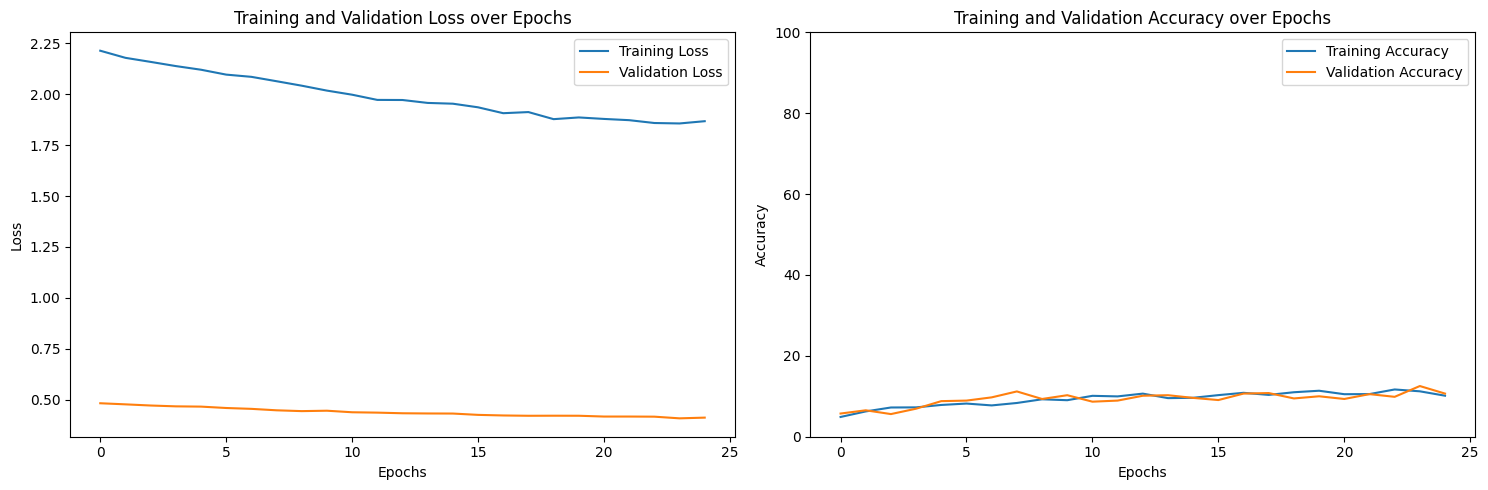

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

In [34]:
torch.save(model.state_dict(), 'model.pth') # Save the model